# Flux Calibration of CHIME/FRB Intensity Data
This jupyter notebook demonstrates how to make Figures 1 through 4 in my paper "Flux Calibration of CHIME/FRB Intensity Data". Hopefully this will serve as a useful resource for those that are interested in CHIME/FRB flux calibration, and, more generally, those looking to use the [CHIME/FRB Open Beam Model](https://github.com/chime-frb-open-data/chime-frb-beam-model).

## Figure 1
This figure illustrates the chromatic effect of FFT beamforming and clamping across the CHIME/FRB bandwidth, expanding upon Figure 1 from [Ng et al. (2017)](https://arxiv.org/pdf/1702.04728.pdf).

On the left-hand side, the position of the dots represents the location of nominal peak sensitivity for each formed beam at a particular frequency. The colored dots enclosed by the gray areas are the selected nearest-neighbor clamped beams, whereas the fainter colored dots are the additional discarded beams. Horizontal black lines represent the nominal clamped beam centers, labeled by the corresponding beam number.

The right-hand side shows the sensitivity versus frequency at the center of each of the clamped beams in the left panel.

For context, the code below for the left-hand side plot essentially reproduces the clamping procedure described in Section 3.1 of [Ng et al. (2017)](https://arxiv.org/pdf/1702.04728.pdf) or the "Zero-padded FFT" section of [Maranda et al. (1989)](https://ui.adsabs.harvard.edu/abs/1989ASAJ...86.1813M/abstract). By padding the data with a large number of zeros before taking a spatial FFT to beamform, the initial output beams (indexed by $m_i$) are dense enough on-sky that there will be a beam at a given frequency close to an arbitrary steering angle. The final FFT-formed beams (indexed by $m_f$) can then be formed by selecting the closest beam at each frequency to the desired steering angle. This final selection step can be efficiently completed by calculating a set of reference indices $t_{m_f}(k)$ to select the closest beams at a reference frequency $f_k$, and then determining the adjustment to those indices $\Delta t_{m_f}$ at all other frequencies offset from the reference frequency $\Delta f$ (see Equations 1 and 2 in [Ng et al. (2017)](https://arxiv.org/pdf/1702.04728.pdf)).

In [1]:
import numpy as np
import cfbm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

%matplotlib inline

In [2]:
# Set parameters for the clamping equations (Equations 1 and 2 in Ng et al. 2017)

# Number of feeds along the focal line of each CHIME cylinder
N = 256
# Speed of light, m/s
c = 2.99*10**8
# Distance between feeds on the focal line, m
d = 0.3048
# Padding factor: a multiplicative factor indicating how much to pad
# the beamforming FFT for Fourier interpolation before clamping.
P = 2 
# Frequencies to plot (we extend beyond 800 MHz just for plotting clarity)
freqs = np.arange(400, 900, 5, dtype=float)

# Steering angle index for the initial padded beams
m_i = np.arange(-8, 8, 1, dtype=float)
# Steering angle index for the final clamped beams
m_f = np.arange(-2, 3, 1, dtype=int)
# Reference frequency for clamping, f_k
f_k = 567.8650141972428

In [3]:
# Calculate the on-sky steering angles for the initial padded beams
steering_angles_initial = []
for m in m_i:
    # Calculate the steering angles for each beam indexed by m_i
    steering_angles = np.arcsin((c * m / (freqs * 10**6 * N * P * d))) * 180. / np.pi
    steering_angles_initial.append(steering_angles)
steering_angles_initial = np.array(steering_angles_initial, dtype=float) # degrees

In [4]:
# Calculate the on-sky steering angles for the final clamped beams at
# the reference frequency f_k
steering_angles_fk = np.arcsin((c * m_f / (f_k * 10**6 * N * d))) * 180. / np.pi # degrees

# Calculate the reference indices for the clamping frequency
ts_mfk = np.array(N * P * f_k * 10**6 * d / c * np.sin(steering_angles_fk * np.pi / 180.) + 0.5, dtype=float)

# Calculate the indices for all frequencies, extrapolating from t_mfk
ts_mf = []
# Iterate through the reference frequency indicies and steering angles
# for each final clamped beam
for ii in range(len(m_f)):
    steering_angle = steering_angles_fk[ii]
    t_mfk = ts_mfk[ii]
    
    # Calculate the index adjustment for each frequency
    delta_t_mf = np.array(N * P * (freqs - f_k) * 10**6 * d / c * np.sin(steering_angle * np.pi / 180.), dtype=float)
    
    # Calculate the indices at each frequency for a gsiven final clamped beam
    t_mf = np.array(np.floor(t_mfk + delta_t_mf), dtype=int) + len(m_i) // 2
    
    ts_mf.append(t_mf)
ts_mf = np.array(ts_mf, dtype=int)

In [5]:
# Finally, use the calculated indices to select the initial beams 
# that will be clamped to form each final beam.
# Save the steering angles for each selected beam, for plotting purposes:
steering_angles_selected = []
for ii in range(len(freqs)):
    tt = ts_mf[:,ii]
    steering_angles = steering_angles_initial[:,ii][tt]
    steering_angles_selected.append(steering_angles)
steering_angles_selected = np.array(steering_angles_selected, dtype=float)

Text(0.5, 0, 'Frequency (MHz)')

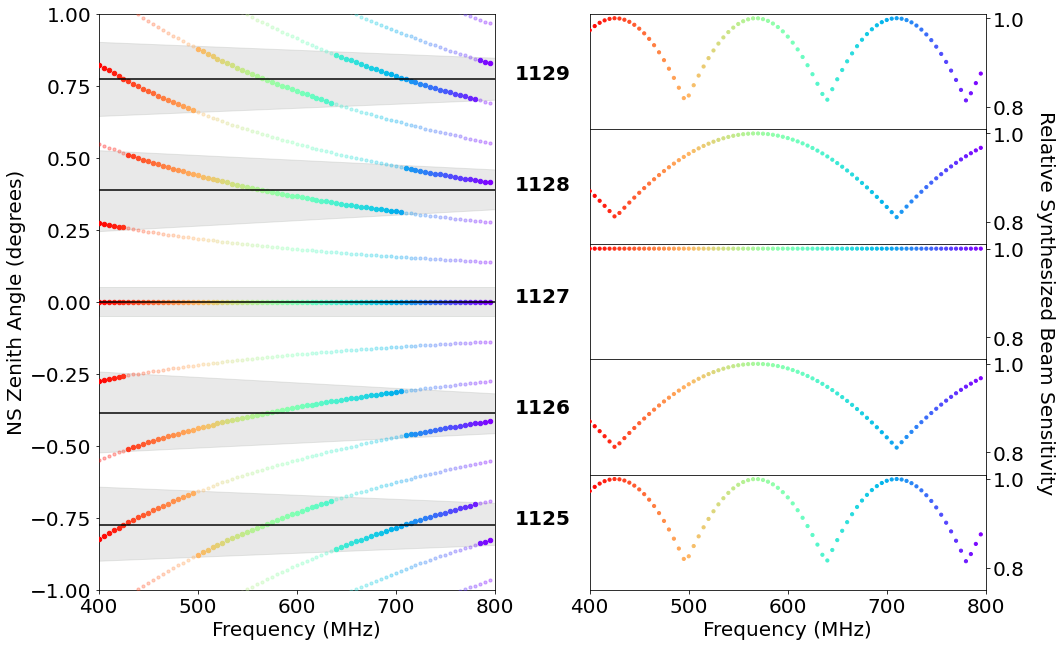

In [6]:
# Now create the plot!
fig = plt.figure(figsize=(11, 8))

left, bottom, width, height = 0., 0., .5, 1.

left_subplot = (left, bottom, width, height)
ax_subplot = plt.axes(left_subplot)

# First, plot all of the dots representing the initial and final beams
freqs_plotted = np.arange(400, 800, 5, dtype=float)
cc = np.linspace(1, 0, len(freqs_plotted))
jet = plt.cm.get_cmap('rainbow')
for ii in range(len(freqs_plotted)):
    freq = freqs[ii]
    
    # The initial padded beams, translucent
    steering_angle_initial = steering_angles_initial[:,ii]
    freqs_initial = np.repeat(freq, len(steering_angle_initial))
    ax_subplot.scatter(freqs_initial, steering_angle_initial, color=jet(cc[ii]), alpha=0.3, s=10, zorder=10)
    
    # The final clamped beams, opaque
    steering_angle_selected = steering_angles_selected[ii]
    freqs_selected = np.repeat(freq, len(steering_angle_selected))
    ax_subplot.scatter(freqs_selected, steering_angle_selected, color=jet(cc[ii]), alpha=1., s=20, zorder=10)

# Plot horizontal black lines to indicate the steering angles
# of the clamped beams at the reference frequency.
for ii in range(len(steering_angles_fk)):
    ax_subplot.axhline(y=steering_angles_fk[ii], lw=1.5, color='black', zorder=10)

steering_angles_selected_T = steering_angles_selected.T
# Plot the grey shaded areas to more clearly outline the clamped beams
for m in range(len(m_f)):
    if m == 2:
        # For the central beam, just plot a simple rectangle of width 0.1 degrees
        w = 0.1
        ax_subplot.axhspan(steering_angles_fk[m]-w/2., steering_angles_fk[m]+w/2., alpha=0.2, color='xkcd:grey', zorder=0)
    else:
        # Otherwise, find the selected beams on either side of the reference 
        # frequency steering angle that occur at the edge of the clamped beam.
        edge_inds = np.diff(np.abs(steering_angles_selected_T[m])) > 0
        beam_angles_top = steering_angles_selected_T[m][:-1][edge_inds]
        beam_angles_bottom = steering_angles_selected_T[m][1:][edge_inds]
        freqs_top = freqs[:-1][edge_inds]
        freqs_bottom = freqs[:-1][edge_inds]
        
        # Add some padding for plotting clarity.
        padding = 0.01
        sign = -1 if m < 2 else 1
        beam_angles_top = beam_angles_top - padding * sign
        beam_angles_bottom = beam_angles_bottom + padding * sign
        
        # Complete linear fits to the top and bottom edges
        beam_angles_interp = np.linspace(-1., 1, 100)
        m, b = np.polyfit(np.sin(beam_angles_top * np.pi/180.), freqs_top, deg=1)
        freqs_fit_top = m * np.sin(beam_angles_interp * np.pi/180.) + b
        m, b = np.polyfit(np.sin(beam_angles_bottom * np.pi/180.), freqs_bottom, deg=1)
        freqs_fit_bottom = m * np.sin(beam_angles_interp * np.pi/180.) + b

        # Fill between the linear fits
        f1 = np.minimum(freqs_fit_top, freqs_fit_bottom)
        f2 = np.repeat(300., len(beam_angles_interp))
        ax_subplot.fill_betweenx(beam_angles_interp, f1, f2, alpha=0.2, color='xkcd:grey', zorder=0)

# Set plot limits
ax_subplot.set_xlabel("Frequency (MHz)")
ax_subplot.set_ylabel("NS Zenith Angle (degrees)")
ax_subplot.set_ylim([-1,1])
ax_subplot.set_xlim([400,800])

# Label the beam numbers
beam_nums = [1125, 1126, 1127, 1128, 1129]
for ii in range(len(beam_nums)):
    ax_subplot.text(820, steering_angles_fk[ii], '{}'.format(beam_nums[ii]), fontsize=20, fontweight='bold')

# Now plot the corresponding beam model sensitivity responses.
# Set up the beam model and get the steering angles positions of 
# the clamped beams at the reference frequency.
bm = cfbm.FFTFormedActualBeamModel(cfbm.current_config)
positions = bm.get_beam_positions(beam_nums, freqs=bm.config["clamp_freq"]).squeeze()

# Iterate through, plotting the sensitivities for each beam number
for jj in range(len(beam_nums)):
    beam_num = beam_nums[jj]
    pos = positions[jj]
    
    # Retrieve the sensitivities for the given beam number, 
    # position, and frequencies
    sensitivities = bm.get_sensitivity(beam_num, pos, freqs_plotted).squeeze()

    # Set up the subplot
    right_subplot = (left+width+0.12, height-height/5.*(jj+1), width, height/5.)
    ax_subplot = plt.axes(right_subplot)
    ax_subplot.yaxis.tick_right()
    ax_subplot.yaxis.set_label_position("right")
    
    ax_subplot.scatter(freqs_plotted, sensitivities, color=jet(cc), alpha=1., s=10, zorder=10)
    ax_subplot.set_ylim([0.75,1.01])
    ax_subplot.set_xlim([400,800])
    if jj < len(beam_nums)-1:
        ax_subplot.xaxis.set_ticklabels([])
    if jj == 2:
        ax_subplot.set_ylabel("Relative Synthesized Beam Sensitivity", rotation=-90, labelpad=30)
ax_subplot.set_xlabel("Frequency (MHz)")

# plt.savefig('./plots/clamping_and_sensitivities.png', dpi=300, bbox_inches='tight')

# Figure 2

This figure shows representations of the East-West sensitivity profile of the CHIME/FRB formed beams.

The left-hand side shows a plot of the East-West profile for the row of beams at zenith at 600 MHz (solid lines), which are attenuated by the primary beam envelope (dotted blue lines). The dashed vertical lines indicate the main lobe of each beam. 

First we create the left-hand side plot.

In [7]:
import numpy as np
import cfbm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

%matplotlib inline

In [8]:
# Instantiate the composite (primary+synthesized beam model)
bm = cfbm.CompositeBeamModel(cfbm.current_config)

# Get the position of beam 1127 at 600 MHz
beam_num = 1127
freq = 600. # MHz
beam_pos = bm.get_beam_positions(beam_num, freqs=np.array([freq]))[0][0]
# Note: we use x and y as coordinates to indicate beam position 
# which are angles in degrees from the origin. We set the origin to be
# (x,y)=(0,0) at zenith, which the synthesized beam grid is centered on.

# Assemble the xy-positions for an East-West slice through the center of
# beams 0127, 1127, 2127, and 3137, where we want to query the 
# beam model sensitivities for plotting.
x_vals = np.linspace(-2.5, 2.5, 500)
y_vals = np.repeat(beam_pos[1], len(x_vals))
pos = np.array([[x_vals[ii], y_vals[ii]] for ii in range(len(x_vals))])

beam_nums = [127, 1127, 2127, 3127]
composite_sensitivities_at_600MHz = []
for bn in beam_nums:
    sensitivities = bm.get_sensitivity(bn, pos, np.array([freq])).squeeze()
    composite_sensitivities_at_600MHz.append(sensitivities)
composite_sensitivities_at_600MHz = np.array(composite_sensitivities_at_600MHz, dtype=float)

In [9]:
# Instantiate just the primary beam model
bm = cfbm.primary.DataDrivenPrimaryBeamModel(cfbm.current_config)
# Obtain primary beam sensitivity at 600 MHz for the same East-West slice
# through the center of beams 0127, 1127, 2127, and 3137
primary_sensitivities = bm.get_sensitivity(pos, np.array([freq]))

Text(-3.2, -0.8, 'Relative Beam Sensitivity')

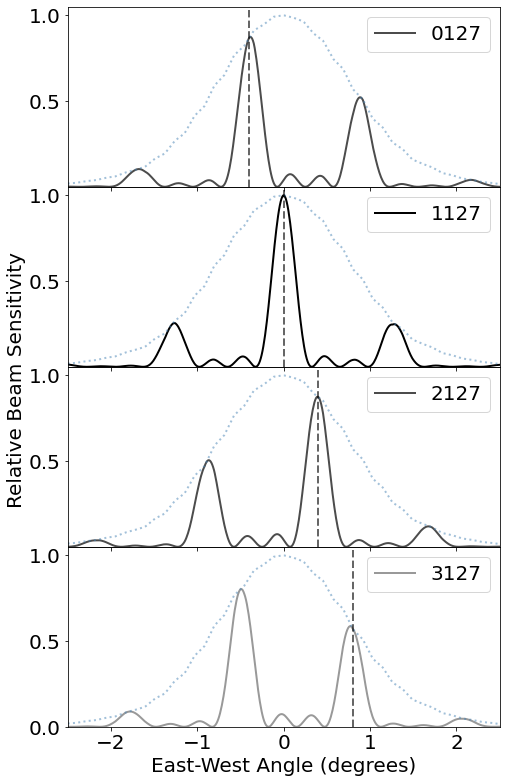

In [10]:
fig = plt.figure(figsize=(6, 10))

left, bottom, width, height = 0., 0., 1., 1./4.

# Set up subplot axes to iterate through
axes = []
for ii in range(len(beam_nums)):
    top_subplot = (left, bottom+height*ii, width, height)
    ax_subplot = plt.axes(top_subplot)
    axes.append(ax_subplot)
axes = axes[::-1]

# Normalize the composite and primary beam sensitivities
# to 1, just for plotting clarity
composite_norm_val = np.max(composite_sensitivities_at_600MHz)
primary_norm_val = np.nanmax(primary_sensitivities)

# Vary the composite beam alphas to indicate offset from zenith
alphas = [0.7, 1., 0.7, 0.4]

# Set the x-coordinates of each of the synthesized beam main lobes
# so that they can be labeled in plot
main_lobe_x = [-0.4, 0., 0.4, 0.8]

# Iterate through plotting each of the beams
for ii in range(len(beam_nums)):                                                                                                                                                                                                                                                                                        
    label_string = "{0:04d}".format(beam_nums[ii])
    
    axes[ii].plot(x_vals, composite_sensitivities_at_600MHz[ii] / composite_norm_val, color='black', lw=2., label=label_string, alpha=alphas[ii])
    axes[ii].plot(x_vals, primary_sensitivities / primary_norm_val, color='steelblue', lw=2., alpha=0.5, linestyle='dotted')
    
    if ii < len(beam_nums)-1:
        axes[ii].xaxis.set_ticklabels([])
        axes[ii].yaxis.get_major_ticks()[0].set_visible(False)
        
    axes[ii].set_xlim([-2.5,2.5])
    axes[ii].set_ylim([0.0,1.05])
    
    lgd = axes[ii].legend(loc="upper right", fontsize=20) 
    
    axes[ii].axvline(x=main_lobe_x[ii], lw=2., color='black', linestyle='dashed', alpha=0.6, zorder=10)

axes[-1].set_xlabel('East-West Angle (degrees)')
axes[-3].text(-3.2, -0.8, 'Relative Beam Sensitivity', fontsize=20, rotation=90)

# plt.savefig('./plots/east_west_beam_profiles.png', dpi=300, bbox_inches='tight')

The right-hand side of Figure 2 shows the East-West profile of beam 1127. On the bottom, the profile is split into five subbands, with colored lines representing each subband (red corresponding to low frequencies and purple corresponding to high frequencies). On the top, the frequency response of the beam at the sidelobe location marked by a vertical black line in the bottom plot.

Now we create the right-hand side plot.

In [11]:
import numpy as np
import cfbm
import chime_frb_constants
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

%matplotlib inline

In [12]:
# This function takes in a 2D spectrum (frequency vs East-West angle) 
# and splits it into n subbands along the frequency axis. 
# Credit to StackOverflow.                                                                                                           
def split_2D(spectrum, n):                                                                                                              
    k, m = divmod(len(spectrum), n)                                                                                                     
    return list(spectrum[i * k + min(i, m):(i + 1) * k + min(i + 1, m), :] for i in range(n))                                          

# Same as split_2D except 1D                                                                                                            
def split_1D(spectrum, n):                                                                                                              
    k, m = divmod(len(spectrum), n)                                                                                                     
    return list(spectrum[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [13]:
beam_num = 1127

# Instantiate the composite beam model
bm = cfbm.CompositeBeamModel(cfbm.current_config, interpolate_bad_freq=True)

# Get list of the center frequencies for each of the 16k 
# CHIME/FRB intensity data frequency channels.
freqs = chime_frb_constants.FREQ
# Retrieve the xy-position of beam 1127 at 600 MHz
freq = 600. # MHz
beam_pos = bm.get_beam_positions(beam_num, freqs=np.array(freq))[0][0]

# Assemble the xy-positions for an East-West slice through the center of
# beam 1127 where we want to query the beam model sensitivities for plotting.
x_vals = np.linspace(-2.5, 2.5, 500)
y_vals = np.repeat(beam_pos[1], len(x_vals))
pos = np.array([[x_vals[ii], y_vals[ii]] for ii in range(len(x_vals))])

# Query for the sensitivities
sensitivities = bm.get_sensitivity(beam_num, pos, freqs).squeeze().T

In [14]:
# Split the sensitivities into subband
spectrum = sensitivities.copy()

num_subbands = 5
spectrum_subbands = split_2D(spectrum, num_subbands)                                                                                

# Average over frequency to obtain the mean sensitivity as a function of 
# East-West angle in each subband.                                                                   
mean_sensitivities = np.array([np.nanmean(s, axis=0) for s in spectrum_subbands])

# Split the frequency array into num_subbands subbands to keep track of                                                             
# which frequencies are contained in each subband.                                                                                            
freq_subbands = split_1D(freqs, num_subbands)                                                                                        

In [15]:
# Now get the sensitivities as a function of frequency for a location
# in the sidelobe of the beam (1.5 degrees off of zenith in the East-West direction).

# Indicate position to query the beam model sensitivities for
sidelobe_pos = np.array([-1.5, beam_pos[1]])

# Query for the sensitivities
sidelobe_sensitivities = bm.get_sensitivity(beam_num, sidelobe_pos, freqs).squeeze().T

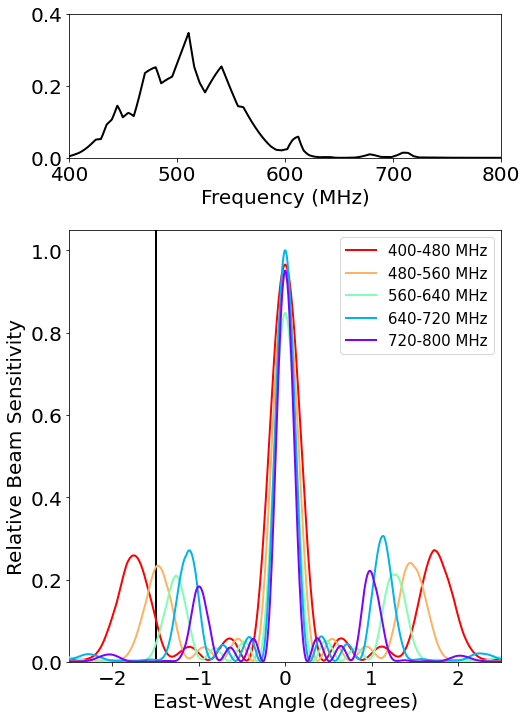

In [16]:
fig = plt.figure(figsize=(6, 10))

left, bottom, width, height = 0., 0., 1., 1.

top_subplot = (left, bottom+height*.7, width, height*.2)
ax_subplot = plt.axes(top_subplot)

# Normalize the composite sensitivities
# to 1, just for plotting clarity
norm_val = np.max(mean_sensitivities)

# Plot the sidelobe sensitivities as a function of frequency
ax_subplot.plot(freqs, sidelobe_sensitivities / norm_val, color='black', lw=2.)
ax_subplot.set_xlabel('Frequency (MHz)')
ax_subplot.set_xlim([400, 800])
ax_subplot.set_ylim([0.,0.4])

bottom_subplot = (left, bottom, width, height*.6)
ax_subplot = plt.axes(bottom_subplot)

# Plot the East-West sensitivities for each subband, 
# changing color according to frequency along the rainbow                                                
# high frequencies -> bluer, low frequencies -> redder                                                                                                
color_idx = np.linspace(0, 1, num_subbands)[::-1]

# Iterate through and plot the sensitivities for each subband
for ii in range(num_subbands):   
    
    # Make label string according to frequency range                                                                                
    min_freq = np.min(freq_subbands[ii])                                                                                               
    max_freq = np.max(freq_subbands[ii])                                                                                                                                             
    label_string = str(int(min_freq)) + "-" + str(int(max_freq)) + " MHz"
    
    
    ax_subplot.plot(x_vals, mean_sensitivities[ii] / norm_val, color=plt.cm.rainbow(color_idx[ii]), lw=2., label=label_string, zorder=20)                    
ax_subplot.axvline(x=sidelobe_pos[0], lw=2., color='black', zorder=10)
ax_subplot.set_xlabel('East-West Angle (degrees)')                                                                                               
ax_subplot.set_ylabel('Relative Beam Sensitivity')                                                                                     
ax_subplot.set_xlim([-2.5,2.5])                                                                                          
ax_subplot.set_ylim([0,1.05])                                                                                                                
lgd = ax_subplot.legend(loc="upper right", fontsize=15)

# plt.savefig('./plots/beam_1127_{}_subbands.png'.format(num_subbands), dpi=300, bbox_inches='tight')

# Figure 3

This figure shows variations in the response of synthesized beam 1128 as a function of frequency and location within the beam. The thick black lines represent the sensitivity versus frequency 10 arcminutes north of the center of beam 1128 (Top) and 10 arcminutes south (Middle). The thin grey dashed line in each of these plots represents the response at beam center. The bottom plot shows the synthesized beam response at the transit location of radio galaxy 3C 147 (thick black line), along with a background-subtracted and normalized observed spectrum of the source with CHIME/FRB (green points). Note that 3C 147 is located 9 arcminutes north of the center of beam 1128.

In [17]:
import numpy as np
import cfbm
import chime_frb_constants
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.coordinates import SkyCoord                                                                                                                                                      
params = {'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

%matplotlib inline

In [18]:
import ephem, pytz, datetime, dateutil
def get_source_transit(source_ra : float, source_dec : float, date_string : str):                                                                                                   
    """ Calculates the time when a source of given position transits zenith 
    at CHIME on a given date. Also returns the number of the CHIME/FRB beam
    that the source passes through, as well as the source's XY beam model 
    coordinate position at the time of transit.                                                                                                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                               
    Parameters                                                                                                                                                                                                                                 
    ----------                                                                                                                                                                                                                                 
    source_ra : float                                                                                                                                                                                                                      
        The RA of the source in degrees                                                                                                                                                                                                        
    source_dec : float                                                                                                                                                                                                                     
        The declination of the source in degrees                                                                                                                                                                                               
    date_string : str                                                                                                                                                                                                                          
        The date to calculate the transit time for, in the form %Y%m%d (e.g. 20190221)                                                                                                                                                         
                                                                                                                                                                                                                                               
    Return                                                                                                                                                                                                                                     
    -------                                                                                                                                                                                                                                    
    transit_time_string : str                                                                                                                                                                                                                  
        The transit time of the calibrator in UTC, format: %Y-%m-%d %H:%M:%S.%f                                                                                                                                                                                                     
    transit_beam_num : int                                                                                                                                                                                                                     
        The 1000 column beam number transited   
    transit_coord_xy : np.array([float, float])
        The XY coordinate position of the source at the time of transit
    """                                                                                                                                                                                                                                        
    # Setup source coordinates in pyephem                                                                                                                                                                                                               
    coord = ephem.Equatorial(ephem.degrees(str(source_ra)), ephem.degrees(str(source_dec)))                                                                                                                                            
    body = ephem.FixedBody()                                                                                                                                                                                                                   
    body._ra = coord.ra                                                                                                                                                                                                                        
    body._dec = coord.dec                                                                                                                                                                                                                      
                                                                                                                                                                                                                                               
    # Setup timezones                                                                                                                                                                                                                          
    pst = pytz.timezone("Canada/Pacific")                                                                                                                                                                                                      
    utc = pytz.timezone("UTC")                                                                                                                                                                                                                 
    date = dateutil.parser.parse(date_string)                                                                                                                                                                                                  
    date = date - pst.utcoffset(date)
    
    # Instantiate beam model                                                                                                                                                                                               
    bm = cfbm.CompositeBeamModel(cfbm.current_config)   
    
    # Calculate the positions of all the FFT formed beams
    # at the clamping frequency
    ii = np.arange(0, 1024)                                                                                                                                                                                                                    
    beam_ids = ((ii // 256)) * 1000 + (ii % 256)                                                                                                                                                                                               
    pos = bm.get_beam_positions(beam_ids, freqs=bm.config["clamp_freq"])                                                                                                                                                                     
                                                                                                                                                                                                                                               
    # Calculate transit time of the source at CHIME                                                                                                                                                                                                                  
    drao = bm.config["location"]                                                                                                                                                                                                              
    drao.date = ephem.Date(date)                                                                                                                                                                                                               
    transit_time = drao.next_transit(body).datetime()                                                                                                                                                                                                                                                                                                                                                                                                                                    
    # Convert transit time to UTC time                                                                                                                                                                                                         
    transit_time = transit_time.replace(tzinfo=pytz.utc)   
    # Create output string of transit time                                                                                                                                                                                                                   
    fmt = "%Y-%m-%d %H:%M:%S.%f"                                                                                                                                                                                                          
    transit_time_string = transit_time.astimezone(utc).strftime(fmt)
    
    # Compute the XY coordinate position of the source at the time of transit
    body.compute()                                                                                                                                                                                                                             
    x_t, y_t = bm.get_position_from_equatorial(                                                                                                                                                                                                   
        np.rad2deg(body.a_ra.real), np.rad2deg(body.a_dec.real), transit_time                                                                                                                                                                  
    )
    transit_coord_xy = np.array([x_t, y_t])
    
    # Calculate the CHIME/FRB beam number that the source transits through  
    dts = np.linspace(-5, 5, 100)                                                                                                                                                                                                              
    xs = []                                                                                                                                                                                                                                    
    ys = []                                                                                                                                                                                                                                    
    for dt in dts:                                                                                                                                                                                                                             
        x, y = bm.get_position_from_equatorial(                                                                                                                                                                                               
            np.rad2deg(body.a_ra.real), 
            np.rad2deg(body.a_dec.real),                                                                                                                                                                                                       
            transit_time + datetime.timedelta(minutes=dt),                                                                                                                                                                                     
        )                                                                                                                                                                                                                                      
        xs.append(x)                                                                                                                                                                                                                           
        ys.append(y)                                                                                                                                                                                        
    diff_pos_y = np.fabs(ys[0] - pos[:, 0, 1])                                                                                                                                                                                                 
    beam_ids_traversed = beam_ids[np.where(diff_pos_y == np.min(diff_pos_y))]                                                                                                                                                                  
    transit_beam_num = beam_ids_traversed.tolist()[1]                                                                                                                                                                                                       
                                                                                                                                                                                                                                               
    return transit_time, transit_beam_num, transit_coord_xy

In [19]:
# Load in spectrum of radio galaxy 3C 147
source_spectrum = np.load('./data/frb_3C_147_2019-03-16_beam_1128.npz')['source_spectrum']

In [20]:
# Instantiate the synthesized beam model
bm = cfbm.FFTFormedActualBeamModel(cfbm.current_config)

# Get the xy-position of beam 1128 at the clamping reference frequency
beam_num = 1128
beam_pos = bm.get_beam_positions(beam_num, freqs=bm.config["clamp_freq"]).squeeze()

# Get list of the center frequencies for each of the 16k 
# CHIME/FRB intensity data frequency channels.
freqs = chime_frb_constants.FREQ

# Query for the sensitivities as a function of frequency at the beam center
beam_center_sensitivities = bm.get_sensitivity(beam_num, beam_pos, freqs).squeeze()

# Query for the sensitivities as a function of frequency offset 10 arcmins
# from the beam center in the positive y-coordinate direction (North)
dist_arcmin = 10. # arcminutes
pos = beam_pos.copy()
pos[1] = pos[1] - dist_arcmin / 60.
pos_offset_sensitivities = bm.get_sensitivity(beam_num, pos, freqs).squeeze()

# Query for the sensitivities as a function of frequency offset 10 arcmins
# from the beam center in the negative y-coordinate direction (South)
pos = beam_pos.copy()
pos[1] = pos[1] + dist_arcmin / 60.
neg_offset_sensitivities = bm.get_sensitivity(beam_num, pos, freqs).squeeze()

# Calculate the offset between the center of beam 1128 at the clamping frequency
# and the radio galaxy 3C 147 when it transits the beam at zenith
source_name = '3C_147'
coord_object = SkyCoord.from_name(source_name)
date = '20200728' # Just a random date, it won't matter for determining the transit coordinates
transit_time, transit_beam_num, transit_coord_xy = get_source_transit(
    coord_object.ra.deg, 
    coord_object.dec.deg,
    date, 
)
print("{} transited through beam {} at {} UTC".format(source_name, transit_beam_num, transit_time))
dist_arcmin = ((beam_pos - transit_coord_xy)*60.)[1]

# Query for the sensitivities as a function of frequency at the location
# of 3C 147 at the time of transit
pos = beam_pos.copy()
pos[1] = pos[1] - dist_arcmin / 60.
source_offset_sensitivities = bm.get_sensitivity(beam_num, pos, freqs).squeeze()

3C_147 transited through beam 1128 at 2020-07-28 17:15:19.202398+00:00 UTC


Text(450, 0.1, '+9 arcmins')

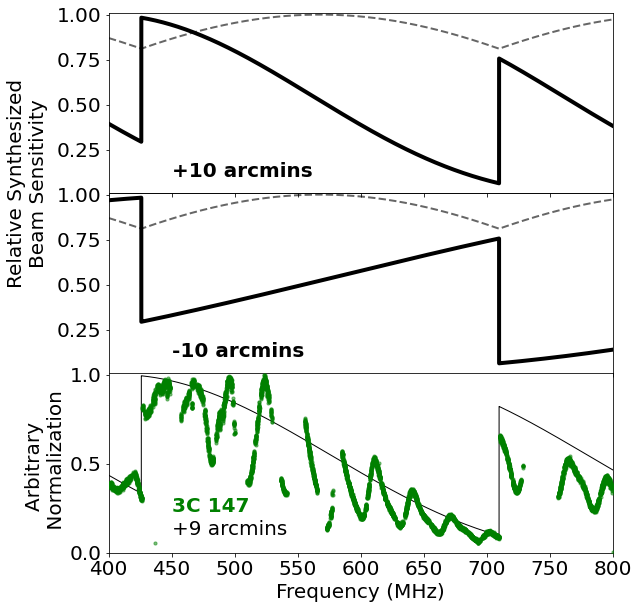

In [21]:
fig = plt.figure(figsize=(7, 10))

left, bottom, width, height = 0., 0., 1., 1./4.

top_subplot = (left, bottom+height*2., width, height)
ax_subplot = plt.axes(top_subplot)

# Plot the beam center sensitivities
ax_subplot.plot(freqs, beam_center_sensitivities, color='black', lw=2., linestyle='dashed', alpha=0.6, zorder=10)
# Plot the positive offset sensitivities
ax_subplot.plot(freqs, pos_offset_sensitivities, lw=4., color='black', zorder=10)

ax_subplot.set_xlim([400,800])
ax_subplot.set_ylim([0.01,1.01])
ax_subplot.text(450, 0.1, '-10 arcmins', fontsize=20, fontweight='bold')
ax_subplot.xaxis.set_ticklabels([])
ax_subplot.set_ylabel("Relative Synthesized\nBeam Sensitivity")
ax_subplot.yaxis.set_label_coords(-0.12, 1.05)

middle_subplot = (left, bottom+height*3., width, height)
ax_subplot = plt.axes(middle_subplot)

# Plot the beam center sensitivities
ax_subplot.plot(freqs, beam_center_sensitivities, color='black', lw=2., linestyle='dashed', alpha=0.6, zorder=10)
# Plot the negative offset sensitivities
ax_subplot.plot(freqs, neg_offset_sensitivities, lw=4., color='black', zorder=10)

ax_subplot.set_xlim([400,800])
ax_subplot.set_ylim([0.01,1.01])
ax_subplot.xaxis.set_ticklabels([])
ax_subplot.text(450, 0.1, '+10 arcmins', fontsize=20, fontweight='bold')

bottom_subplot = (left, bottom+height*1., width, height)
ax_subplot = plt.axes(bottom_subplot)

# Normalize the source spectrum for comparison to beam model
norm_val = np.nanmax(source_spectrum)
source_spectrum = source_spectrum / norm_val

# Plot source spectrum and sensitivities at the location of source
ax_subplot.scatter(freqs, source_spectrum, alpha=0.5, s=10, zorder=20, color='green')
ax_subplot.plot(freqs, source_offset_sensitivities, lw=1., color='black', zorder=10)

ax_subplot.set_ylabel("Arbitrary \n Normalization")
ax_subplot.set_xlabel("Frequency (MHz)")
ax_subplot.set_ylim([0.0,1.01])
ax_subplot.set_xlim([400,800])
ax_subplot.text(450, 0.23, '3C 147', fontsize=20, color='green', fontweight='bold')
ax_subplot.text(450, 0.1, '+9 arcmins', fontsize=20)

# plt.savefig('./plots/clamping_NS_and_data.png', dpi=300, bbox_inches='tight')

# Figure 4

This figure shows a sampling of CHIME/FRB synthesized beam responses at the locations of several bright supernova remnant and radio galaxy transits (black lines), along with background-subtracted and normalized observed spectra of each source (green points). The source name, zenith angle, beam number, and offset from beam center are labeled to the right of each plot.

In [22]:
import numpy as np
import cfbm
import chime_frb_constants
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.coordinates import SkyCoord                                                                                                                                                      
params = {'axes.labelsize':20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

%matplotlib inline

In [23]:
import ephem, pytz, datetime, dateutil
def get_source_transit(source_ra : float, source_dec : float, date_string : str):                                                                                                   
    """ Calculates the time when a source of given position transits zenith 
    at CHIME on a given date. Also returns the number of the CHIME/FRB beam
    that the source passes through, as well as the source's XY beam model 
    coordinate position at the time of transit.                                                                                                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                               
    Parameters                                                                                                                                                                                                                                 
    ----------                                                                                                                                                                                                                                 
    source_ra : float                                                                                                                                                                                                                      
        The RA of the source in degrees                                                                                                                                                                                                        
    source_dec : float                                                                                                                                                                                                                     
        The declination of the source in degrees                                                                                                                                                                                               
    date_string : str                                                                                                                                                                                                                          
        The date to calculate the transit time for, in the form %Y%m%d (e.g. 20190221)                                                                                                                                                         
                                                                                                                                                                                                                                               
    Return                                                                                                                                                                                                                                     
    -------                                                                                                                                                                                                                                    
    transit_time_string : str                                                                                                                                                                                                                  
        The transit time of the calibrator in UTC, format: %Y-%m-%d %H:%M:%S.%f                                                                                                                                                                                                     
    transit_beam_num : int                                                                                                                                                                                                                     
        The 1000 column beam number transited   
    transit_coord_xy : np.array([float, float])
        The XY coordinate position of the source at the time of transit
    """                                                                                                                                                                                                                                        
    # Setup source coordinates in pyephem                                                                                                                                                                                                               
    coord = ephem.Equatorial(ephem.degrees(str(source_ra)), ephem.degrees(str(source_dec)))                                                                                                                                            
    body = ephem.FixedBody()                                                                                                                                                                                                                   
    body._ra = coord.ra                                                                                                                                                                                                                        
    body._dec = coord.dec                                                                                                                                                                                                                      
                                                                                                                                                                                                                                               
    # Setup timezones                                                                                                                                                                                                                          
    pst = pytz.timezone("Canada/Pacific")                                                                                                                                                                                                      
    utc = pytz.timezone("UTC")                                                                                                                                                                                                                 
    date = dateutil.parser.parse(date_string)                                                                                                                                                                                                  
    date = date - pst.utcoffset(date)
    
    # Instantiate beam model                                                                                                                                                                                               
    bm = cfbm.CompositeBeamModel(cfbm.current_config)   
    
    # Calculate the positions of all the FFT formed beams
    # at the clamping frequency
    ii = np.arange(0, 1024)                                                                                                                                                                                                                    
    beam_ids = ((ii // 256)) * 1000 + (ii % 256)                                                                                                                                                                                               
    pos = bm.get_beam_positions(beam_ids, freqs=bm.config["clamp_freq"])                                                                                                                                                                     
                                                                                                                                                                                                                                               
    # Calculate transit time of the source at CHIME                                                                                                                                                                                                                  
    drao = bm.config["location"]                                                                                                                                                                                                              
    drao.date = ephem.Date(date)                                                                                                                                                                                                               
    transit_time = drao.next_transit(body).datetime()                                                                                                                                                                                                                                                                                                                                                                                                                                    
    # Convert transit time to UTC time                                                                                                                                                                                                         
    transit_time = transit_time.replace(tzinfo=pytz.utc)   
    # Create output string of transit time                                                                                                                                                                                                                   
    fmt = "%Y-%m-%d %H:%M:%S.%f"                                                                                                                                                                                                          
    transit_time_string = transit_time.astimezone(utc).strftime(fmt)
    
    # Compute the XY coordinate position of the source at the time of transit
    body.compute()                                                                                                                                                                                                                             
    x_t, y_t = bm.get_position_from_equatorial(                                                                                                                                                                                                   
        np.rad2deg(body.a_ra.real), np.rad2deg(body.a_dec.real), transit_time                                                                                                                                                                  
    )
    transit_coord_xy = np.array([x_t, y_t])
    
    # Calculate the CHIME/FRB beam number that the source transits through  
    dts = np.linspace(-5, 5, 100)                                                                                                                                                                                                              
    xs = []                                                                                                                                                                                                                                    
    ys = []                                                                                                                                                                                                                                    
    for dt in dts:                                                                                                                                                                                                                             
        x, y = bm.get_position_from_equatorial(                                                                                                                                                                                               
            np.rad2deg(body.a_ra.real), 
            np.rad2deg(body.a_dec.real),                                                                                                                                                                                                       
            transit_time + datetime.timedelta(minutes=dt),                                                                                                                                                                                     
        )                                                                                                                                                                                                                                      
        xs.append(x)                                                                                                                                                                                                                           
        ys.append(y)                                                                                                                                                                                        
    diff_pos_y = np.fabs(ys[0] - pos[:, 0, 1])                                                                                                                                                                                                 
    beam_ids_traversed = beam_ids[np.where(diff_pos_y == np.min(diff_pos_y))]                                                                                                                                                                  
    transit_beam_num = beam_ids_traversed.tolist()[1]                                                                                                                                                                                                       
                                                                                                                                                                                                                                               
    return transit_time, transit_beam_num, transit_coord_xy

In [24]:
# Populate the source names, the CHIME/FRB synthesized beams that the sources
# transit through, and the date that the dataset used in this figure was saved
source_names = ['SNR_G130.7+03.1','CAS_A','CYG_A','TAU_A','HERCULES_A']
transit_beams = [1167, 1152, 1105, 1059, 1024]
dates = ['2019-03-16','2019-06-13','2020-04-21','2019-04-02','2019-04-22']

In [25]:
# Iterate through each dataset and extract the source spectrum, the synthesized
# beam sensitivities at the location of the source, the source declination,
# and the offset of the source from the transit beam center

# Instantiate the synthesized beam model
bm = cfbm.FFTFormedActualBeamModel(cfbm.current_config)
# Get list of the center frequencies for each of the 16k 
# CHIME/FRB intensity data frequency channels.
freqs = chime_frb_constants.FREQ

spectra = []
sensitivities = []
source_dec_deg = []
source_offset_arcmin = []
for ii in range(len(source_names)):
    source_name = source_names[ii]
    beam_num = transit_beams[ii]
    date_string = dates[ii]
    
    print('Extracting info for: {}, {}, {}'.format(source_name, beam_num, date_string))
    
    # Extract the source spectrum
    data_file = './data/frb_{0}_{1}_beam_{2}.npz'.format(source_name, date_string, beam_num)
    source_spectrum = np.load(data_file)['source_spectrum']
    spectra.append(source_spectrum)
    
    # Query the source coordinates
    coord_object = SkyCoord.from_name(source_name)
    date = '20200728' # Just a random date, it won't matter for determining the transit coordinates
    transit_time, transit_beam_num, transit_coord_xy = get_source_transit(
        coord_object.ra.deg,
        coord_object.dec.deg,
        date,
    )
    source_dec_deg.append(coord_object.dec.deg)
    
    # Get the transit beam position at the reference clamping frequency
    beam_pos = bm.get_beam_positions(beam_num, freqs=bm.config["clamp_freq"]).squeeze()
    # Calculate the distance between the beam location and the source
    dist_arcmin = ((beam_pos - transit_coord_xy)*60.)[1] # arcminutes
    source_offset_arcmin.append(dist_arcmin)
    
    # Query for the sensitivities as a function of frequency at the location
    # of the source at the time of transit
    pos = beam_pos.copy()
    pos[1] = pos[1] - dist_arcmin / 60.
    beam_sensitivities = bm.get_sensitivity(beam_num, pos, freqs).squeeze()
    sensitivities.append(beam_sensitivities)
    

Extracting info for: SNR_G130.7+03.1, 1167, 2019-03-16
Extracting info for: CAS_A, 1152, 2019-06-13
Extracting info for: CYG_A, 1105, 2020-04-21
Extracting info for: TAU_A, 1059, 2019-04-02
Extracting info for: HERCULES_A, 1024, 2019-04-22


Text(0.5, 0, 'Frequency (MHz)')

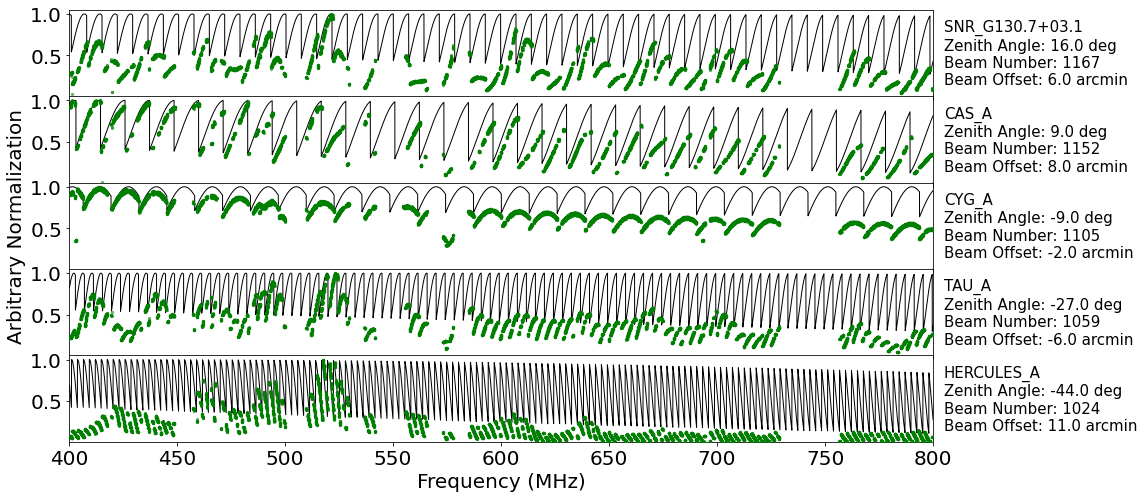

In [26]:
fig = plt.figure(figsize=(12, 6))

left, bottom, width, height = 0., 0., 1., 1. / len(source_names)

# Extract the latitude for CHIME. This will be used to calculate
# source zenith angles
drao = bm.config["location"]
latitude_CHIME = drao.lat * 180. / np.pi
for ii in range(len(source_names)):
    subplot = (left, bottom+height*(len(source_names)-ii-1), width, height)
    ax_subplot = plt.axes(subplot)
    
    # Extract the information for each source
    source_name = source_names[ii]
    beam_num = transit_beams[ii]
    spectrum = spectra[ii]
    beam_sensitivity = sensitivities[ii]
    source_dec = source_dec_deg[ii]
    source_offset = source_offset_arcmin[ii]
    
    # Normalize the spectrum to 1, for comparison to the beam model
    norm_val = np.nanmax(spectrum)
    spectrum = spectrum / norm_val
    
    # Plot the source spectrum and beam senitivities as a function of frequency
    ax_subplot.scatter(freqs, spectrum, alpha=.5, s=5, zorder=20, color='green')
    ax_subplot.plot(freqs, beam_sensitivity, lw=1., color='black', zorder=10)
    
    if ii < len(source_names)-1:
        ax_subplot.xaxis.set_ticklabels([])
    if ii == len(source_names)//2:
        ax_subplot.set_ylabel("Arbitrary Normalization")
    zenith_angle = source_dec - latitude_CHIME
    label_string = '{0}\nZenith Angle: {1} deg\nBeam Number: {2}\nBeam Offset: {3} arcmin'.format(
        source_name, 
        round(zenith_angle), 
        beam_num, 
        round(source_offset),
    )
    
    ax_subplot.text(805, 0.15, label_string, fontsize=15)
    ax_subplot.set_ylim([0.01,1.05])
    ax_subplot.set_xlim([400,800])
ax_subplot.set_xlabel("Frequency (MHz)")

# plt.savefig('./plots/clamping_sampling.png', dpi=300, bbox_inches='tight')